# Data simulation

Using the Dynamic Generalised Models library https://github.com/ruivieira/python-ssm

In [1]:
from pssm.dglm import NormalDLM
from pssm.structure import UnivariateStructure
import numpy as np

np.random.seed(23)

Create a (univariate) DGLM with a period of 7 days (weekly) and a simple seasonal component with one harmonic.

This corresponds to simulating daily hits on a web server with a weekly pattern.

We will keep the underlying mean with a small variance to make it a (relatively) stable time-series.

In [2]:
period = 7

structure = UnivariateStructure.locally_constant(1.4) + \
            UnivariateStructure.cyclic_fourier(period=period, harmonics=1, W=np.identity(2)*2)

In [3]:
ndlm = NormalDLM(structure=structure, V=1.5)

In [4]:
structure.G

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.6234898 ,  0.78183148],
       [ 0.        , -0.78183148,  0.6234898 ]])

Simulate a dataset with 365 days.

Mean server hits prior of `100`.

In [5]:
m0 = np.array([100, 0, 0])
C0 = np.identity(3)
state0 = np.random.multivariate_normal(m0, C0)

states = [state0]

N = 365

for t in range(1, N):
    states.append(ndlm.state(states[t-1]))
    
obs = [None]
for t in range(1, N):
    obs.append(ndlm.observation(states[t]))

Data for the first two "months" (~60 days).

Text(0, 0.5, 'Hits')

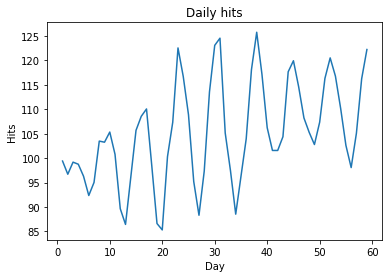

In [6]:
import matplotlib.pyplot as plt

plt.plot(obs[0:60])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")

Add random anomalies by increasing the state randomly.

We set the anomaly times manually just for testing, randomise later.

In [7]:
def generate_anomalous_data(structure, 
                            n_obs,
                            m0,
                            C0,
                            V,
                            anomaly_times,
                            ratio):
    ndlm = NormalDLM(structure=structure, V=V)
    state0 = np.random.multivariate_normal(m0, C0)

    states = [state0]

    for t in range(1, n_obs):
        states.append(ndlm.state(states[t-1]))
    
    for t in anomaly_times:
        states[t] = states[t] * ratio
    
    obs = [None]
    for t in range(1, N):
        obs.append(ndlm.observation(states[t]))

    return obs

Generate a new dataset with anomalies at day `27`, `53`, `270` (just for testing).

In [8]:
obs = generate_anomalous_data(structure, 365, m0, C0, 2.5, [27, 53, 270], 3.0)

We will need to use observations as arrays often, so do it now.

In [9]:
Y = np.array(obs[1:]).reshape(-1,1)

Text(0, 0.5, 'Hits')

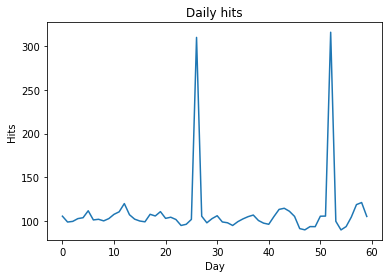

In [10]:
import matplotlib.pyplot as plt

plt.plot(Y[:60])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")

Convert into dataframe (just for plotting, really...)

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(Y, columns=["y"])
df.head()

,y
0,105.301872
1,98.575037
2,99.327438
3,102.514398
4,103.531128


# (Local) outlier detection

Train the local outlier detector with the whole dataset[^1].

[^1]: Again, just for training purposes.

In [13]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(contamination='auto', novelty=True)
clf.fit(Y)

LocalOutlierFactor(novelty=True)

Store the detected anomalies (if any) on the dataframe.

In [14]:
anomalies = clf.predict(Y)

In [15]:
df['anomaly'] = anomalies

Plot the data for the first 60 days, along with the anomalies (red).

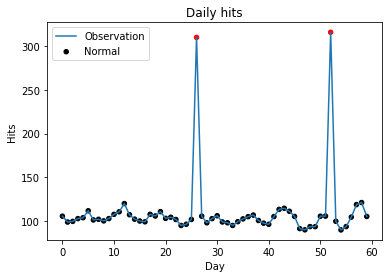

In [16]:
d = df.head(60)
plt.plot(Y[:60])
plt.scatter(x=range(60), y=d['y'], c=list(d['anomaly'].map({1: 'black', -1: 'red'})), s=20)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['Observation', 'Normal'])

# LSTM forecast

Forecast the data using LSTM.

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Offset the data (history size `1`, i.e. one step behind).

In [39]:
def create_offset(dataset, history=1):
    x, y = [], []
    for i in range(len(dataset)-history-1):
        a = dataset[i:(i+history), 0]
        x.append(a)
        y.append(dataset[i + history, 0])
    return np.array(x), np.array(y)

Normalise data for LSTM.

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(Y)

Split into train and test datasets.

In [41]:
train_size = 250
test_size = N - train_size
train, test = data[:train_size,:], data[train_size:N,:]

In [42]:
history = 1
X_train, y_train = create_offset(train, history)
X_test, y_test = create_offset(test, history)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Fit the LSTM.

In [43]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, history)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=125, batch_size=2, verbose=0)

Add predictions for plotting.

In [44]:
LSTM_pred = {}
LSTM_pred["train"] = model.predict(X_train)
LSTM_pred["test"] = model.predict(X_test)

Un-normalise.

In [45]:
LSTM_pred["train"] = scaler.inverse_transform(LSTM_pred["train"])
y_train = scaler.inverse_transform([y_train])
LSTM_pred["test"] = scaler.inverse_transform(LSTM_pred["test"])
y_test = scaler.inverse_transform([y_test])

In [54]:
len(data)

364

Plot the time between 200th and 300th days.

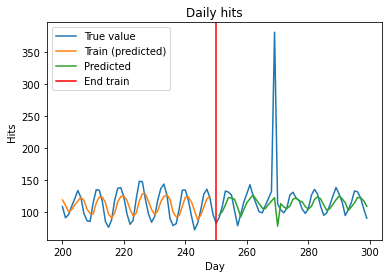

In [56]:
pred_train = np.empty_like(data)
pred_train[:, :] = np.nan
cutoff = len(LSTM_pred["train"])
pred_train[history:(cutoff+history),:] = LSTM_pred["train"]

pred_test = np.empty_like(data)
pred_test[:, :] = np.nan
pred_test[(cutoff+(history*2)+1):(N-2),:] = LSTM_pred["test"]

start = 200
end = 300
w = range(start, end)
plt.plot(w, scaler.inverse_transform(data)[start:end])
plt.plot(w, pred_train[start:end])
plt.plot(w, pred_test[start:end])
plt.axvline(x=250, c="red")
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['True value', 'Train (predicted)', "Predicted", "End train"])
plt.show()

Timepoint `t=268` (non-anomalous in our data)

In [ ]:
Y[268]

Should be non-anomalous (`p=1`)

In [ ]:
clf.predict(np.array(Y[268]).reshape(-1, 1))

Predicted observation:

In [ ]:
prediction = model.predict(scaler.transform(np.array(Y[268]).reshape(-1, 1)))
print(f"Observed value = {Y[268][0]}, predicted = {scaler.inverse_transform(prediction)[0][0]}")

Now, timepoint `t=269` (**anomalous** in our data)

In [ ]:
Y[269]

Should be **anomalous** (`p=-1`)

In [ ]:
clf.predict(np.array(Y[269]).reshape(-1, 1))

Predicted observation:

In [ ]:
prediction = model.predict(scaler.transform(np.array(Y[269]).reshape(-1, 1)))
print(f"Observed value = {Y[269][0]}, predicted = {scaler.inverse_transform(prediction)[0][0]}")